First, we stack spectra to get a (scaled) average spectrum, weighted equally between the fits files (scaled first then added). 

In [1]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request
import numpy as np
from astropy.io import fits
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
"""Choosing a list of .fits files to stack:"""


"""For testing purposes we select the high dor cluster from hierarchical clustering and form a list, data, in which each element is a list of 
[wave, flux, ivar] for one spectrum
"""
files = ["cluster_results/k-means_clusters.csv", "cluster_results/gmm_clusters.csv", "cluster_results/hierarchical_clusters.csv"]
filename = files[2]  # selecting hierarchical for now
clusters = pd.read_csv(filename)
two = clusters[clusters["Cluster"]==2]["SDSS_ID"].tolist() # list of file names selecting cluster 2
one = clusters[clusters["Cluster"]==1]["SDSS_ID"].tolist() # selecting 1
zero = clusters[clusters["Cluster"]==0]["SDSS_ID"].tolist() # selecting 0



# Now we also try using actual DoR ranges
all = pd.read_csv("data/E-INSPIRE_I_master_catalogue.csv")

high = all[all['DoR']>0.6]
high_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(high['plate'], high['mjd'], high['fiberid'])]

med1 = all[all['DoR']<0.6]
med = med1[med1['DoR']>0.3]
med_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(med['plate'], med['mjd'], med['fiberid'])]

low = all[all['DoR']<0.3]
low_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(low['plate'], low['mjd'], low['fiberid'])]



spectra = two  # change to whichever you want

In [3]:
data = []

def clean_and_normalize_spectrum(wave, flux, ivar):
    # Remove NaN and inf values
    good_idx = np.isfinite(flux) & np.isfinite(ivar)
    wave, flux, ivar = wave[good_idx], flux[good_idx], ivar[good_idx]
    
    # Simple normalization by median flux
    median_flux = np.median(flux)
    if median_flux != 0:
        flux = flux / median_flux
        ivar = ivar * (median_flux ** 2)
    
    return wave, flux, ivar

def load_spectrum(filename):
    with fits.open(filename) as hdul:
        coadd = hdul[1].data  # Extension 1 contains the spectrum
        flux = coadd['flux']
        loglam = coadd['loglam']
        ivar = coadd['ivar']
        specobj = hdul[2].data
        z = specobj['Z'][0]
        
        loglam *= 1/(1+z)
        wavelength = 10**loglam
    
       #wavelength_rfm = wavelength / (1+z)
        wavelength, flux, ivar = clean_and_normalize_spectrum(wavelength, flux, ivar)

        return wavelength, flux, ivar

for id in spectra:
    wave, flux, ivar = load_spectrum("fits_shortlist/"+id) # data[0]
    data.append([wave, flux, ivar])


print(data[0][0][0]) # shortest wavelength for first spectrum
print(data[1][0][0])  #"" "" for second spectrum
# Clearly we will need to do some aligning ... ?

1033.3159
914.11365


In [4]:
from scipy import interpolate

def resample_spectrum(wave, flux, ivar, new_wave):
    # Interpolate flux onto new wavelength grid
    f = interpolate.interp1d(wave, flux, bounds_error=False, fill_value=0)
    new_flux = f(new_wave)
    
    # Interpolate ivar (need to handle this carefully)
    f_ivar = interpolate.interp1d(wave, ivar, bounds_error=False, fill_value=0)
    new_ivar = f_ivar(new_wave)
    
    return new_flux, new_ivar
    
# Create common wavelength grid
wave_min = max([data[i][0][0] for i in range(len(data))])  # Maximum of all minimum wavelengths
wave_max = min([data[i][0][-1] for i in range(len(data))]) # Minimum of all maximum wavelengths
wave_common = np.linspace(wave_min, wave_max, num=3828)

# Resample all spectra
resampled_data = []
for spectrum in data:
   new_flux, new_ivar = resample_spectrum(spectrum[0], spectrum[1], spectrum[2], wave_common)
   resampled_data.append([wave_common, new_flux, new_ivar])

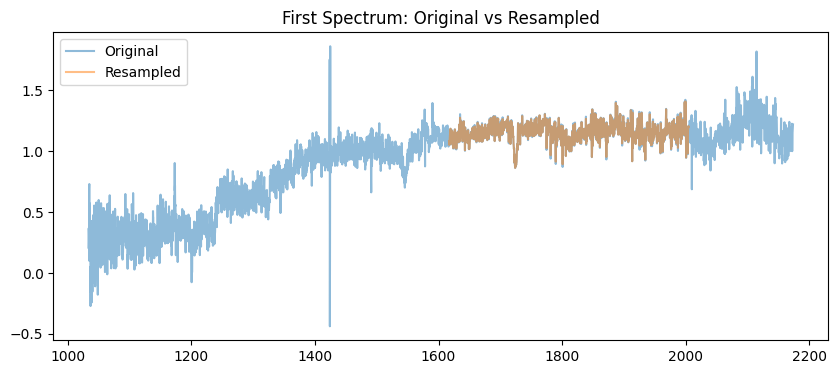

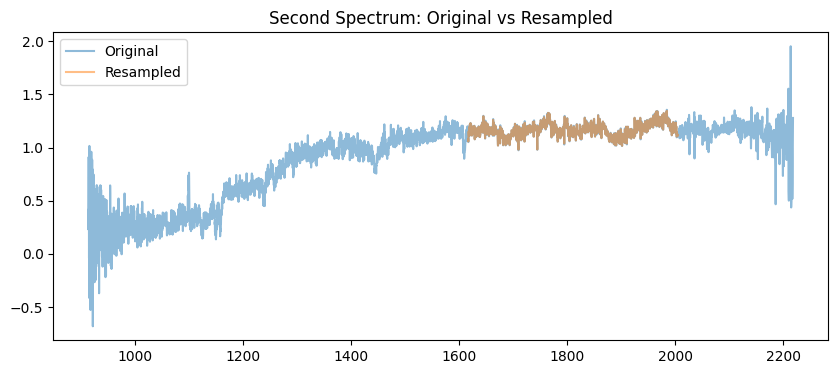

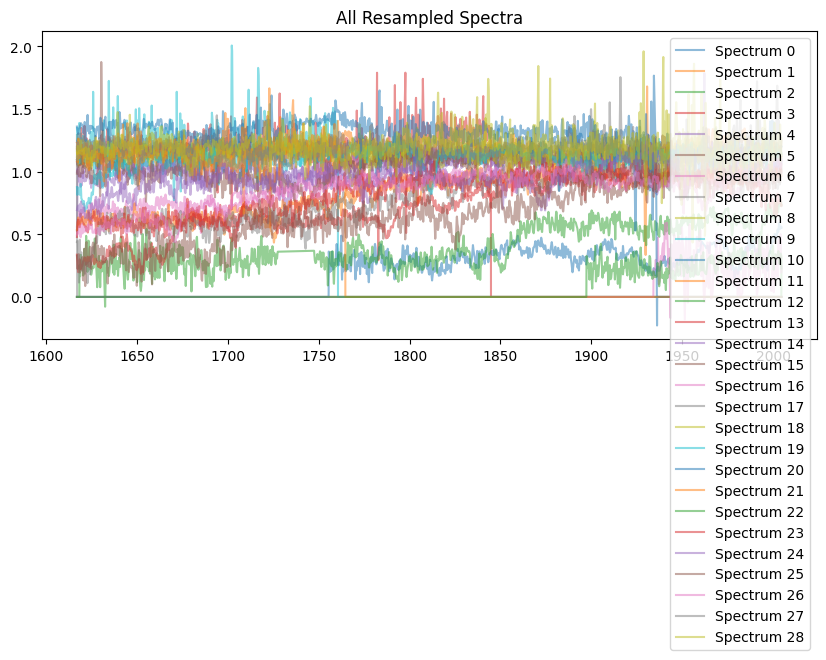

Common wavelength range: 2004.63 to 1616.94 Å


In [5]:
plt.figure(figsize=(10, 4))
plt.plot(data[0][0], data[0][1], label='Original', alpha=0.5)
plt.plot(resampled_data[0][0], resampled_data[0][1], label='Resampled', alpha=0.5)
plt.legend()
plt.title('First Spectrum: Original vs Resampled')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(data[1][0], data[1][1], label='Original', alpha=0.5)
plt.plot(resampled_data[1][0], resampled_data[1][1], label='Resampled', alpha=0.5)
plt.legend()
plt.title('Second Spectrum: Original vs Resampled')
plt.show()

# Plot all resampled spectra together
plt.figure(figsize=(10, 4))
for i, spectrum in enumerate(resampled_data):
    plt.plot(spectrum[0], spectrum[1], label=f'Spectrum {i}', alpha=0.5)
plt.legend()
plt.title('All Resampled Spectra')
plt.show()

# Print wavelength ranges
print(f"Common wavelength range: {wave_min:.2f} to {wave_max:.2f} Å")

In [6]:
def safe_combine_ivar(*ivars):
    ivar_stack = np.stack(ivars)
    
    # Create mask for any invalid values
    mask = np.any((ivar_stack == 0) | np.isinf(ivar_stack), axis=0)
    combined = np.zeros_like(ivars[0])
    
    # Combine valid values
    valid = ~mask
    if np.any(valid):
        # Sum of 1/ivar for valid points
        sum_inv_ivar = np.sum(1.0/ivar_stack[:, valid], axis=0)
        combined[valid] = 1.0 / sum_inv_ivar
    
    return combined

def combine_spectra(aligned_spectra):
    # Extract components
    wavelength = aligned_spectra[0][0]  # All wavelengths should be the same
    fluxes = [spec[1] for spec in aligned_spectra]
    ivars = [spec[2] for spec in aligned_spectra]
    
    # Calculate mean flux
    combined_flux = np.mean(fluxes, axis=0)
    
    # Combine inverse variances
    combined_ivar = safe_combine_ivar(*ivars)
    
    return wavelength, combined_flux, combined_ivar

def safe_errors(stacked_ivar):
    errors = np.zeros_like(stacked_ivar)
    valid = (stacked_ivar > 0) & np.isfinite(stacked_ivar)
    errors[valid] = 1.0 / np.sqrt(stacked_ivar[valid])
    return errors

wavelength, flux, combined_ivar = combine_spectra(resampled_data)
errors = safe_errors(combined_ivar)  # use combined_ivar instead of ivar


Now we fit ppxf as normal. I use example "ppxf_example)gas_sdss_tied.ipynb" for guidance / example. 

In [7]:
c = 299792.458 # speed of light in km/s
lam_gal = wavelength
ln_lam_gal = np.log(lam_gal)  # Natural logarithm
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
noise = np.full_like(flux, 0.01635)           # Assume constant noise per pixel here

In [8]:
dlam_gal = np.gradient(lam_gal)  # Size of every pixel in Angstroms

hdul = fits.open('fits_shortlist/spec-0273-51957-0005.fits')
coadd = hdul[1].data 
wdisp = coadd['wdisp']  # assuming that the wdisp is constant between the two spectra for now.

fwhm_gal = 2.355*wdisp*dlam_gal 

In [9]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

In [10]:
basename = f"spectra_{sps_name}_9.0.npz"
ppxf_dir = Path(lib.__file__).parent
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

fwhm_gal_dic = {"lam": lam_gal, "fwhm": fwhm_gal}
sps = lib.sps_lib(filename, velscale, fwhm_gal_dic)

stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)


lam_range_gal = np.array([np.min(lam_gal), np.max(lam_gal)]) # should be 1+redshift here - what to do for stacked spectra? Using 1 as a default
gas_templates, gas_names, gas_wave = \
    util.emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm_gal_dic)
templates = np.column_stack([stars_templates, gas_templates])
n_temps = stars_templates.shape[1]
print(n_temps)

/Users/charl/Documents/PythonPlay/AS01_Testing/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/charl/Documents/PythonPlay/AS01_Testing/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [292]:
component = [0]*n_temps  # Single stellar kinematic component=0 for all templates
component += [1]*len(gas_names)   # First 6 gas templates 
component = np.array(component)
moments = [2]*len(np.unique(component))  # Now this will create only 2 sets of moments (stars and gas)

print(component.shape)
print(templates.shape)
vel0 = c * np.log(1)  # redshift meant to be in here too, using 1 as default?
sol = [vel0, 200]
start = [sol for j in range(len(moments))]  # adopt the same starting value for both gas and stars

(169,)
(17316, 169)


 Best Fit:       Vel     sigma
 comp.  0:     -1784       714
 comp.  1:     -1729      1000
chi2/DOF: 7.070; DOF: 3814; degree = -1; mdegree = 10
method = capfit; Jac calls: 18; Func calls: 278; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 11/169
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10     0.9031      0.13   -1729  1000
Comp:  1                    H9      0.000      0.13   -1729  1000
Comp:  1                    H8      13.97      0.15   -1729  1000
Comp:  1                  Heps      0.000      0.92   -1729  1000
Comp:  1                Hdelta      1.998      0.13   -1729  1000
Comp:  1                Hgamma      12.13      0.13   -1729  1000
Comp:  1                 Hbeta     0.1292      0.13   -1729  1000
Comp:  1                Halpha      5.054      0.31   -1729  1000
Comp:  1 

Text(0.5, 1.0, 'pPXF fit with emiles SPS templates')

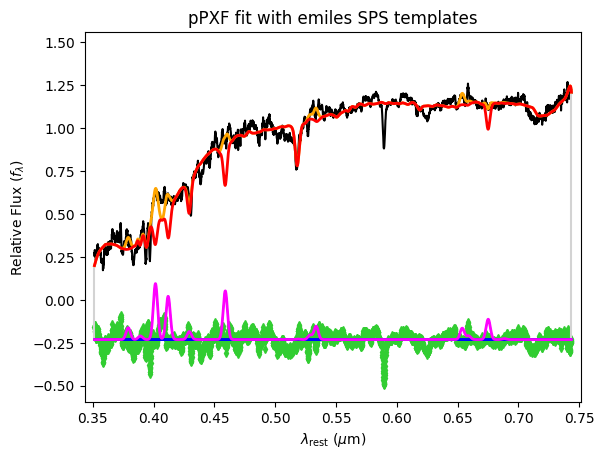

In [293]:
degree= -1
mdegree = 10
t = clock()

pp = ppxf(templates, flux, noise, velscale, start, plot=False, # changed "galaxy" to flux here
            moments=moments, degree=degree, mdegree=mdegree, 
            lam=lam_gal, component=component, 
            gas_component=component > 0, gas_names=gas_names,
            lam_temp=sps.lam_temp)

# removed tied and inequality constraints 
"""pp = ppxf(templates, flux, noise, velscale, start, plot=False, # changed galaxy to flux here
            moments=moments, degree=degree, mdegree=mdegree, 
            lam=lam_gal, component=component, tied=tied, 
            gas_component=component > 0, gas_names=gas_names,
            constr_kinem=constr_kinem, lam_temp=sps.lam_temp)"""


print(f"Elapsed time in pPXF: {(clock() - t):.2f}")
pp.plot()
plt.title(f"pPXF fit with {sps_name} SPS templates")